In [1]:
# Import required libraries and set display configurations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for high-resolution plots in Jupyter
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.unicode_minus'] = False

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Generate synthetic classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_clusters_per_class=1,
    random_state=42
)

# Create feature names
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nTarget distribution:")
print(df['target'].value_counts(normalize=True))

Dataset shape: (1000, 11)

First 5 rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0  -3.358483   3.159918   0.827163   0.069638  -6.715639  -2.708559   
1   2.071819  -4.055419  -2.615940  -2.599432   3.053752   0.366795   
2  -0.633460   0.712482   2.024390  -0.432639  -1.307929   0.419320   
3  -0.464478   0.892442   2.521010   2.766580  -1.933734  -1.418018   
4   1.042426  -1.192605  -2.071386  -0.131231   0.545377   0.379060   

   feature_6  feature_7  feature_8  feature_9  target  
0   0.183206   1.113502   1.730759   1.228394       1  
1  -0.392171  -1.191720  -1.220516   1.899925       0  
2  -1.469510  -0.719051   1.155005   2.018026       0  
3   1.391760  -2.430279   1.308295  -0.270896       1  
4  -0.062978  -1.325591   2.037936   0.115414       0  

Target distribution:
target
1    0.502
0    0.498
Name: proportion, dtype: float64


In [3]:
# Data preprocessing pipeline
def preprocess_data(df):
    """
    Preprocess the dataset: separate features and target
    """
    # Separate features and target
    X = df.drop('target', axis=1)
    y = df['target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training target distribution:", np.bincount(y_train) / len(y_train))

Training set shape: (800, 10)
Test set shape: (200, 10)
Training target distribution: [0.4975 0.5025]


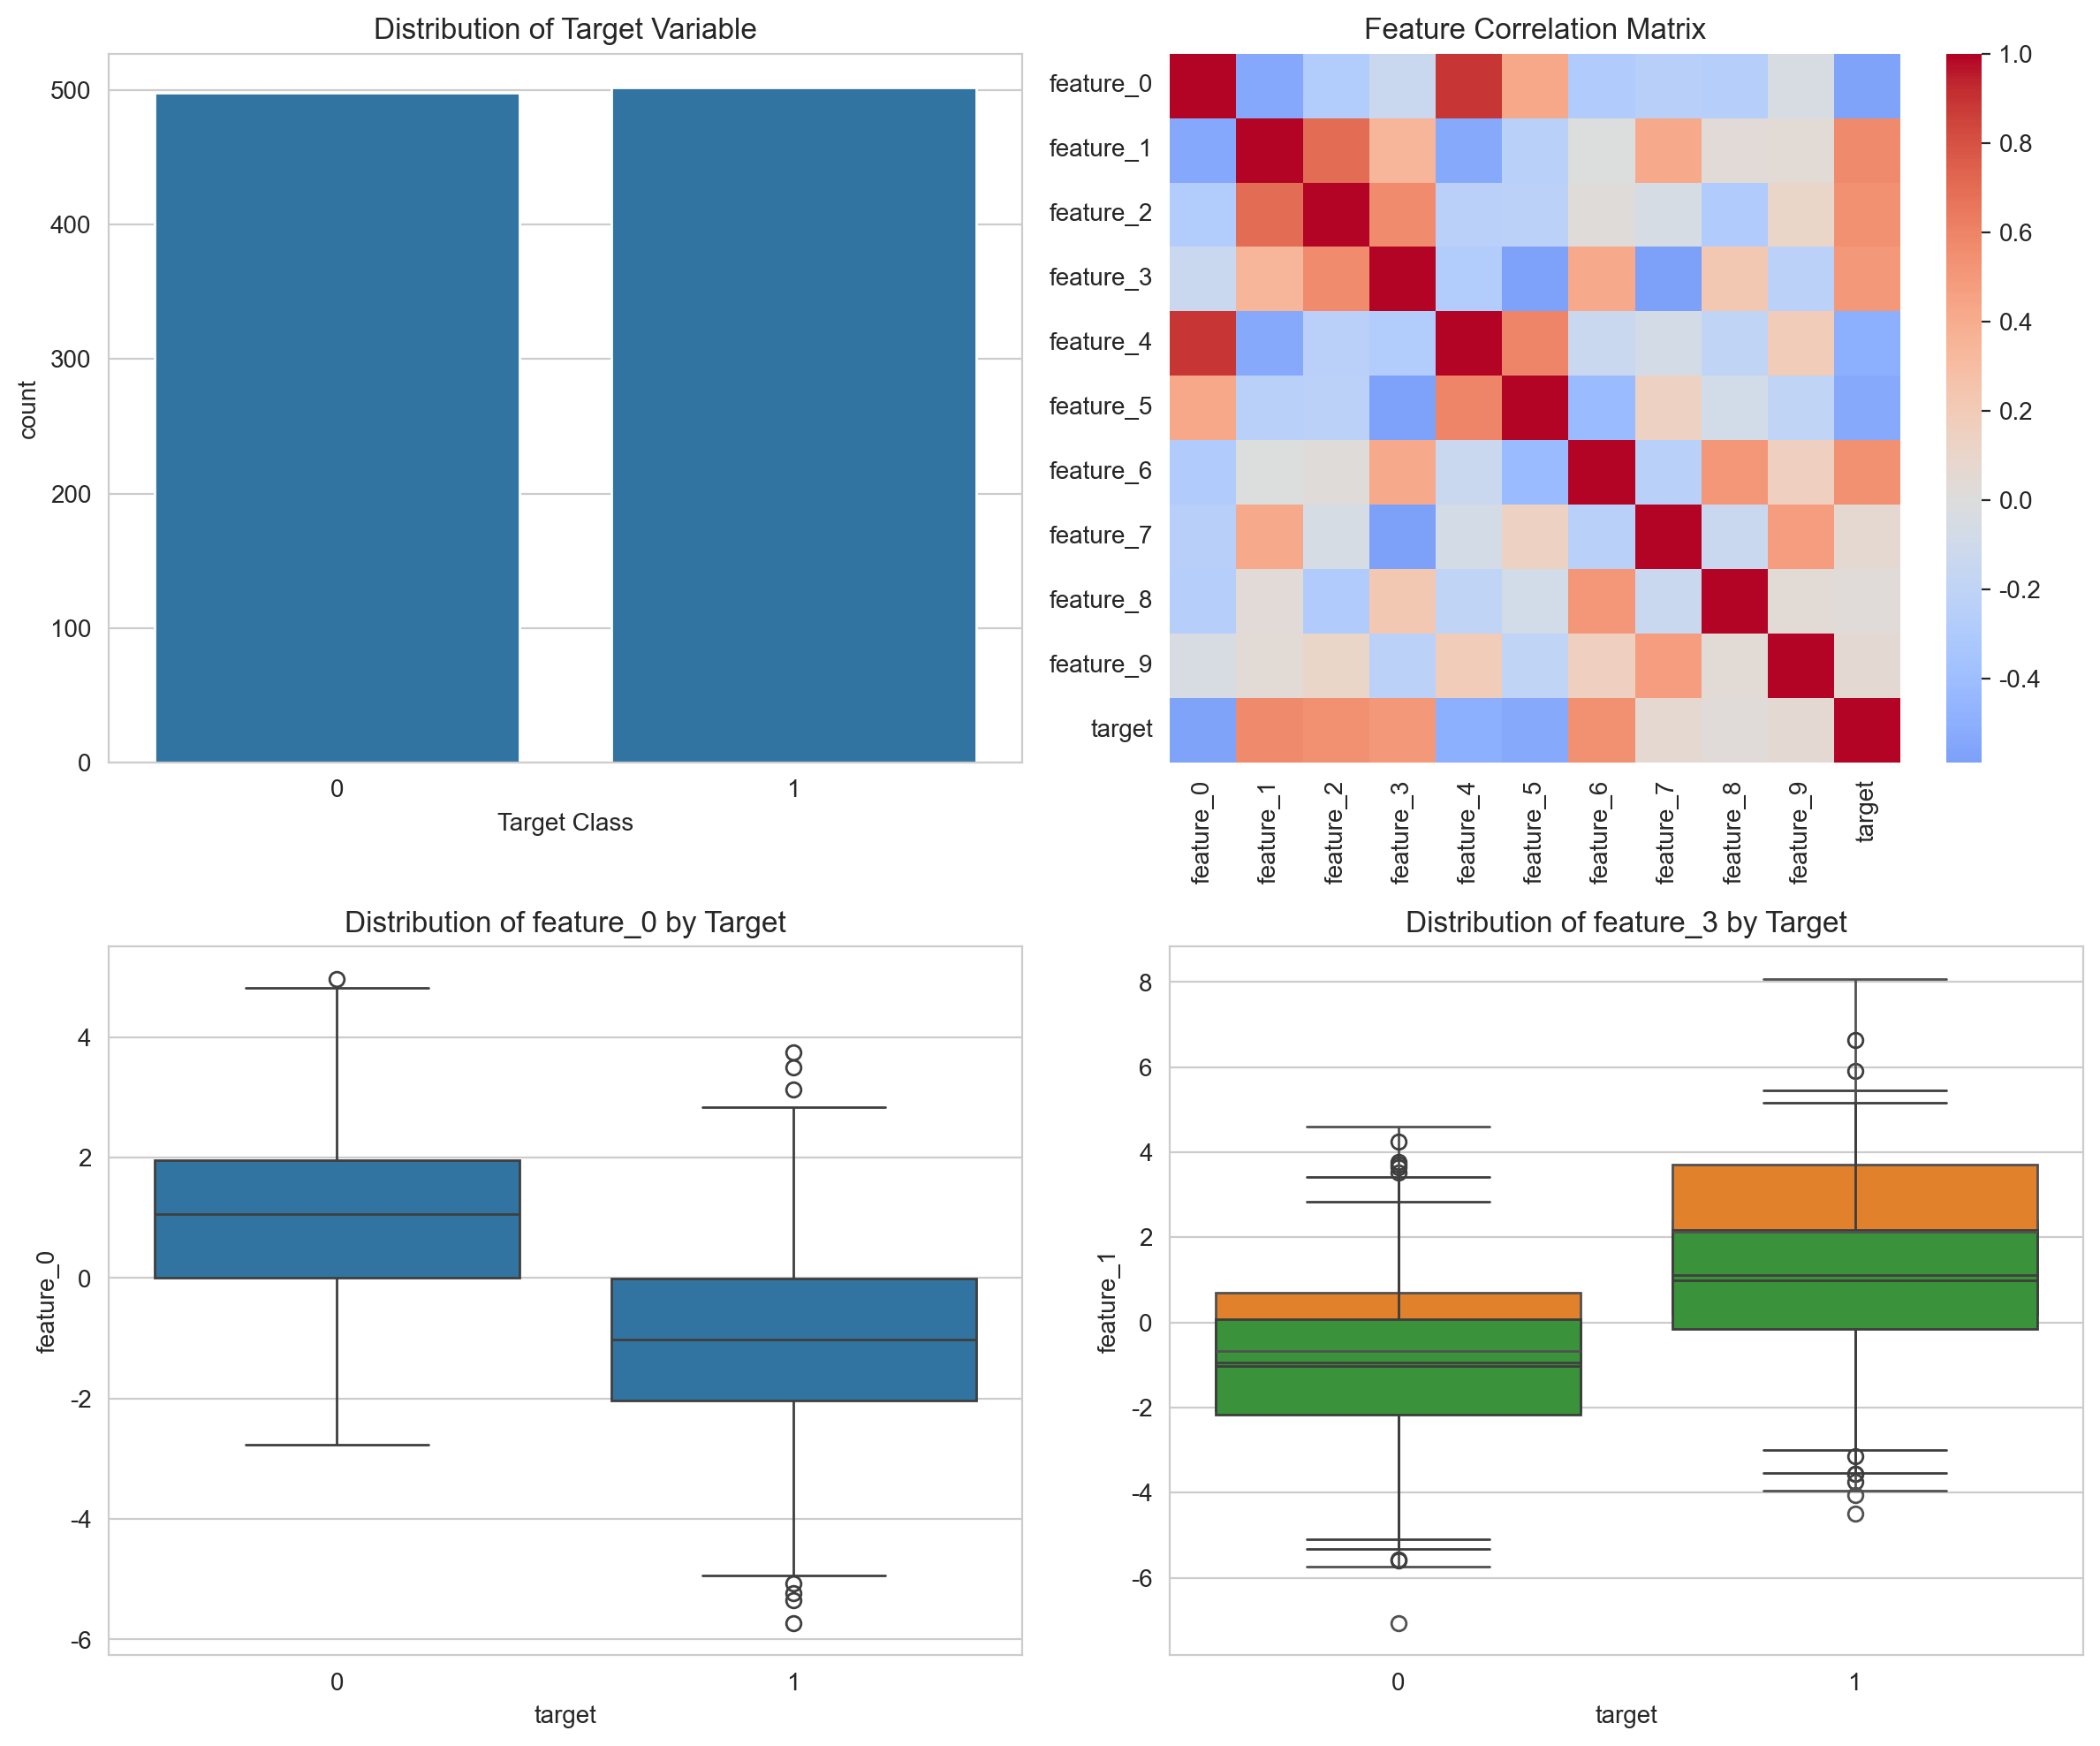

Statistical Summary of Features:
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -0.011969     0.129752     0.706672    -0.016344    -0.498672   
std       1.808578     1.898759     2.557031     1.971651     2.887880   
min      -5.727136    -5.573060    -7.065298    -5.587152    -8.955052   
25%      -1.232362    -1.181259    -1.115875    -1.400761    -2.538922   
50%       0.001062     0.085923     0.677475    -0.038077    -0.696768   
75%       1.207415     1.437913     2.418557     1.397473     1.373167   
max       4.971656     5.911466     8.080278     6.645896    10.746849   

         feature_5    feature_6    feature_7    feature_8    feature_9  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.033892    -0.042067    -0.919433     1.017852     1.008241   
std       1.845013     1.855610     1.483525     1.603109     1.733232   
min 

In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 2)

# Distribution of target variable
sns.countplot(x='target', data=df, ax=axes[0,0])
axes[0,0].set_title('Distribution of Target Variable')
axes[0,0].set_xlabel('Target Class')

# Feature correlation heatmap
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, ax=axes[0,1])
axes[0,1].set_title('Feature Correlation Matrix')

# Feature distribution (first 4 features)
for i, feature in enumerate(feature_names[:4]):
    row, col = (1, i//2) if i >= 2 else (1, i)
    sns.boxplot(data=df, x='target', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature} by Target')

plt.tight_layout()
plt.show()

# Print statistical summary
print("Statistical Summary of Features:")
print(df.describe())

In [6]:
# Train AdaBoost model
base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)  # Weak learner (stump)
model = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
auc_score = roc_auc_score(y_test, y_pred_proba)

print("Model Performance Metrics:")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Performance Metrics:
Training Accuracy: 0.9888
Test Accuracy: 0.9650
AUC Score: 0.9889

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       100
           1       0.94      0.99      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



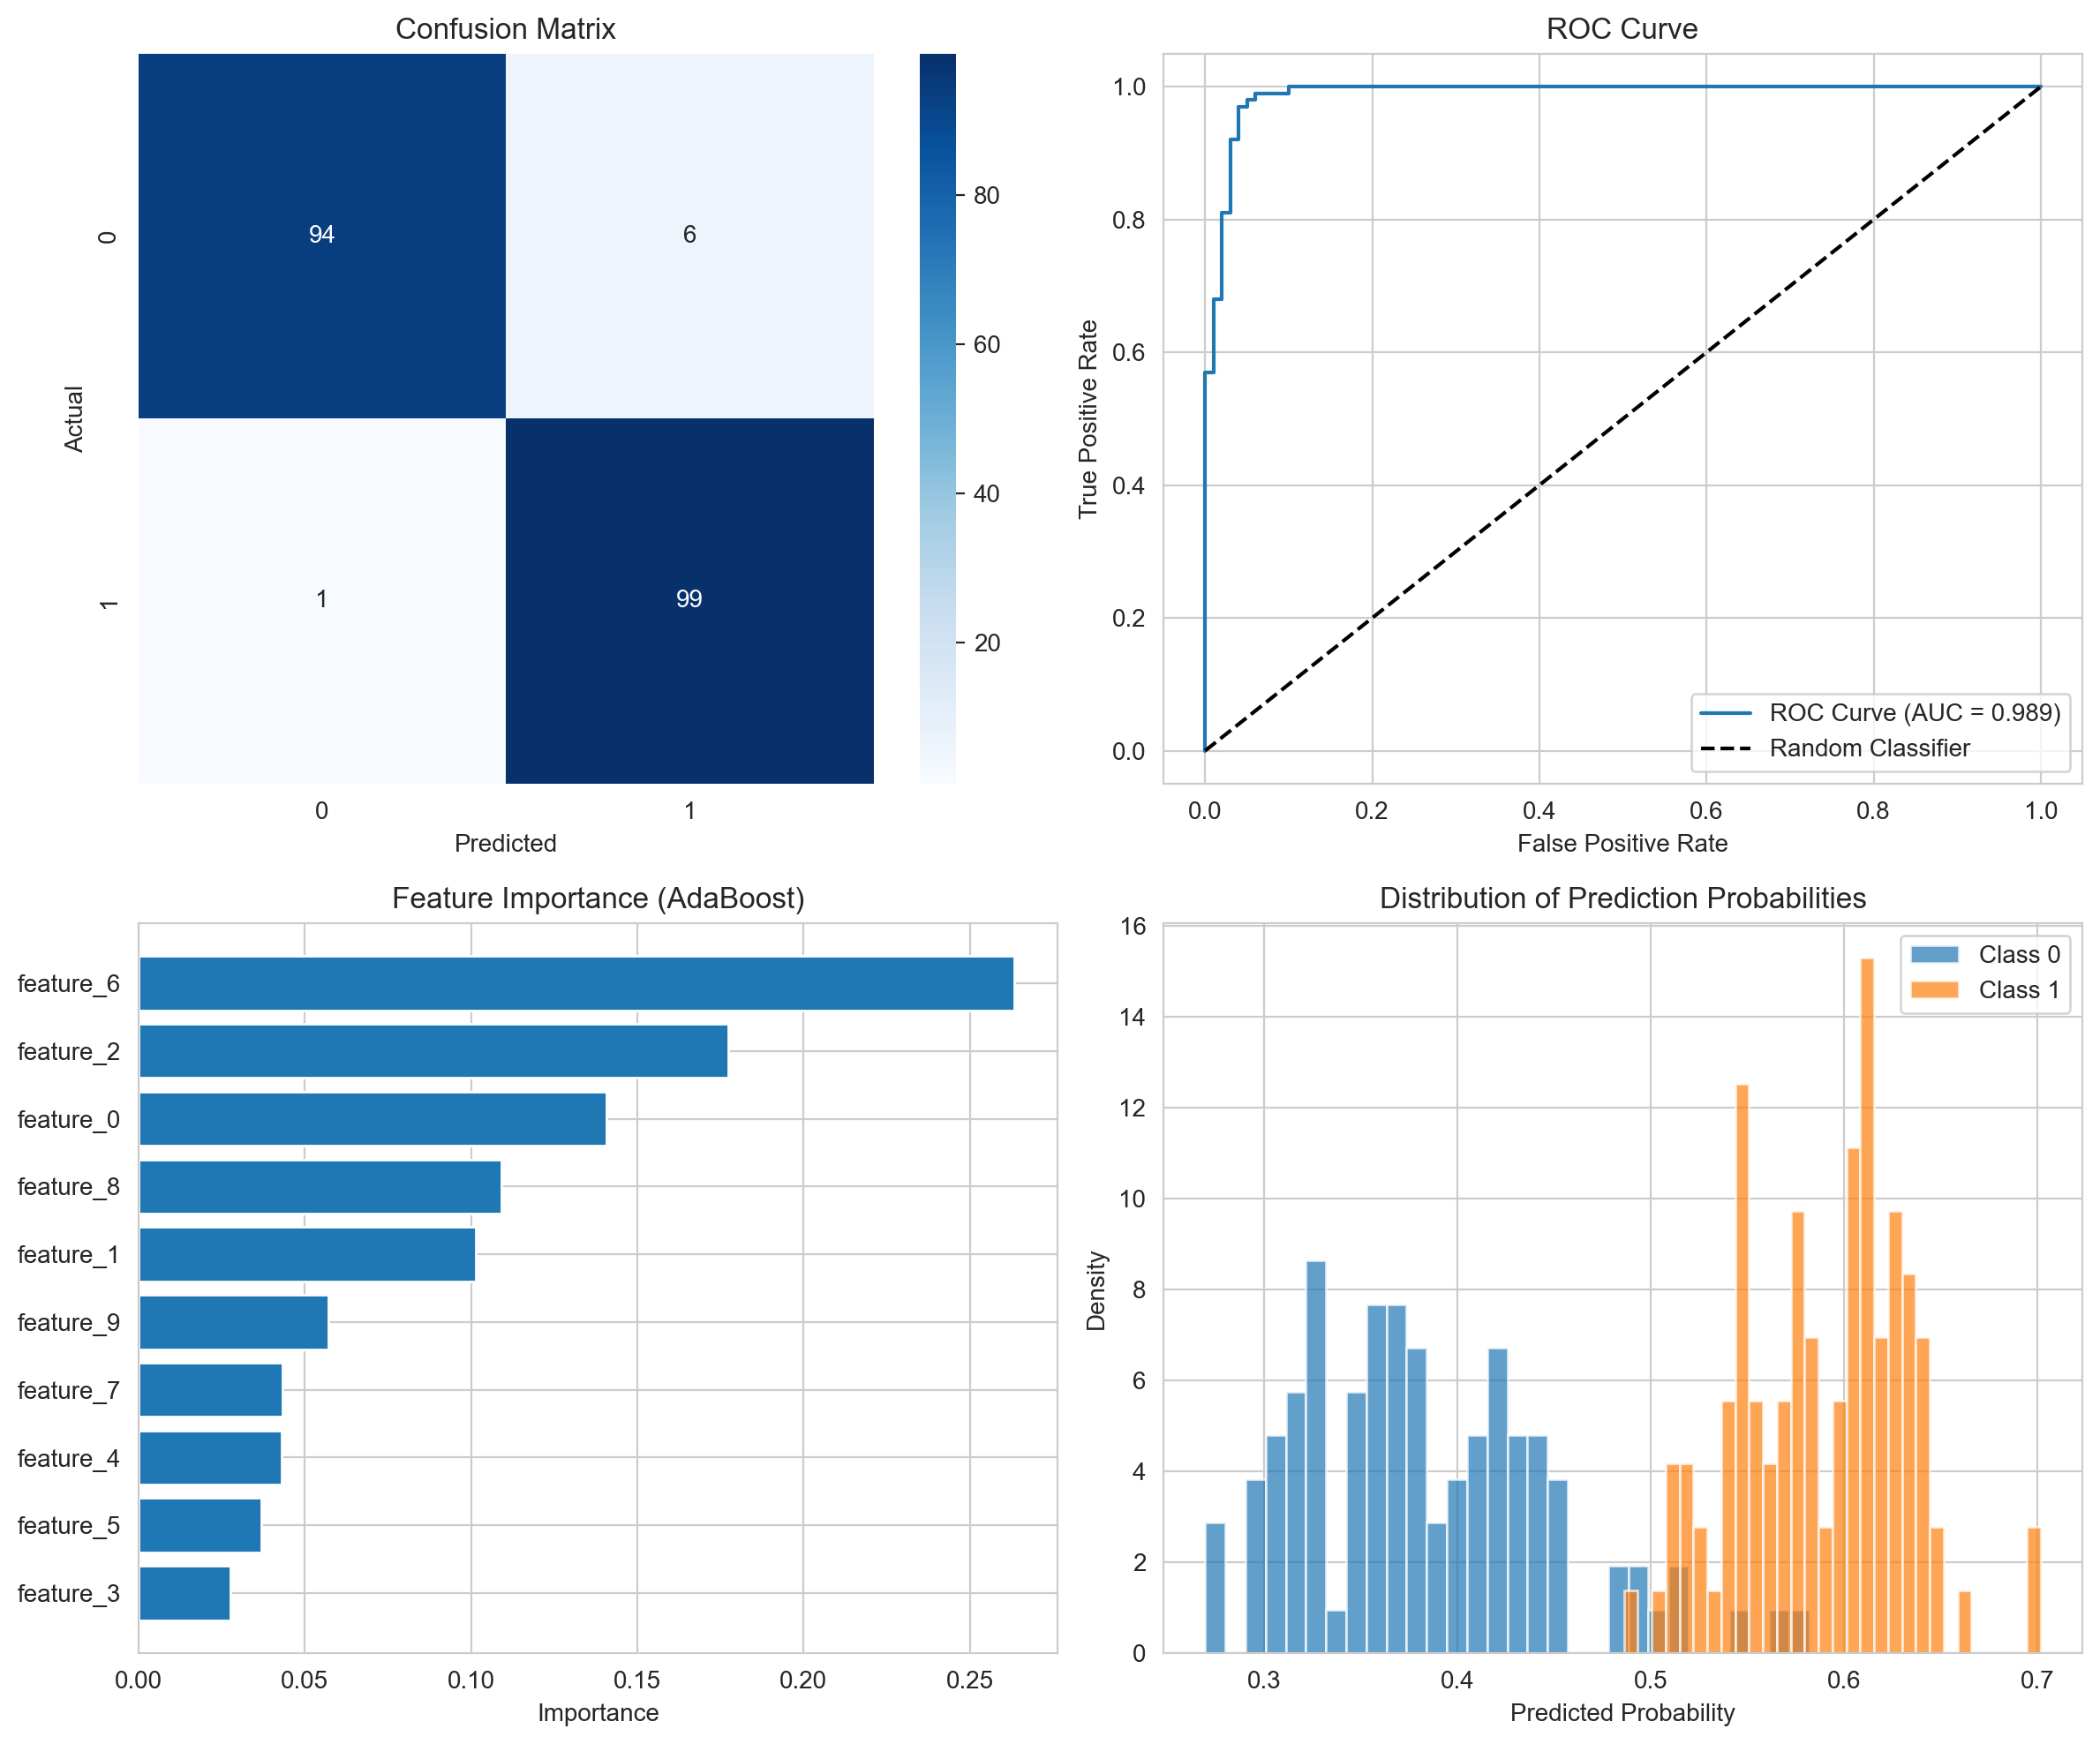

In [7]:
# Visualization of results
fig, axes = plt.subplots(2, 2)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()

# Feature Importance (AdaBoost coefficients)
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

axes[1,0].barh(range(len(feature_importance)), feature_importance['importance'])
axes[1,0].set_yticks(range(len(feature_importance)))
axes[1,0].set_yticklabels(feature_importance['feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Feature Importance (AdaBoost)')

# Prediction probability distribution
axes[1,1].hist(y_pred_proba[y_test==0], bins=30, alpha=0.7, label='Class 0', density=True)
axes[1,1].hist(y_pred_proba[y_test==1], bins=30, alpha=0.7, label='Class 1', density=True)
axes[1,1].set_xlabel('Predicted Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution of Prediction Probabilities')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [8]:
# Model interpretation and insights
print("AdaBoost Model Parameters:")
print(f"Number of estimators: {model.n_estimators}")
print(f"Learning rate: {model.learning_rate}")
print(f"Base estimator: {type(model.estimator).__name__}")

print("\nFeature Importance Ranking:")
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
print(feature_importance_sorted.round(4))

# Calculate and display prediction statistics
print(f"\nPrediction Statistics:")
print(f"Mean of predicted probabilities: {y_pred_proba.mean():.2f}")
print(f"Std of predicted probabilities: {y_pred_proba.std():.2f}")
print(f"Mean of actuals: {y_test.mean():.2f}")

# Show estimator weights (how much each weak learner contributes)
estimator_weights = model.estimator_weights_
print(f"\nFirst 10 estimator weights: {estimator_weights[:10].round(4)}")
print(f"Last 10 estimator weights: {estimator_weights[-10:].round(4)}")

AdaBoost Model Parameters:
Number of estimators: 100
Learning rate: 1.0
Base estimator: DecisionTreeClassifier

Feature Importance Ranking:
     feature  importance
6  feature_6      0.2633
2  feature_2      0.1774
0  feature_0      0.1408
8  feature_8      0.1092
1  feature_1      0.1014
9  feature_9      0.0571
7  feature_7      0.0432
4  feature_4      0.0431
5  feature_5      0.0370
3  feature_3      0.0276

Prediction Statistics:
Mean of predicted probabilities: 0.49
Std of predicted probabilities: 0.12
Mean of actuals: 0.50

First 10 estimator weights: [1.273  1.405  1.0893 0.9515 0.88   0.5006 0.941  0.4973 0.7218 0.9975]
Last 10 estimator weights: [0.1337 0.1644 0.28   0.3203 0.407  0.2182 0.2313 0.396  0.2094 0.3703]
